In [ ]:
%pip install numpy matplotlib deepxde torch

In [ ]:
#!pip uninstall torch -y
#!pip install torch torchvision torchaudio

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import torch

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



In [ ]:
#dde.backend.set_default_backend('pytorch')
#%cat ~/.deepxde/config.json

In [ ]:
#PARÂMETROS DOMINIO
L = 20
TF = 80

#PARAMETROS
D = 0.0139
P = 0.0453

In [ ]:
Dl = D / (P * L**2)

#DECLARAÇÃO DOMÍNIO ESPACIAL E TEMPORAL
geom = dde.geometry.Interval(0, 1)
time = dde.geometry.TimeDomain(0, TF * P)
geomtime = dde.geometry.GeometryXTime(geom, time)

#EQUAÇÃO RESIDUAL
def pde(x, c):

    c_t = dde.grad.jacobian(c, x, i=0, j=1)
    c_xx = dde.grad.hessian(c, x, i=0, j=0)
    return c_t - (Dl * c_xx + c)

#CONDIÇÃO INICIAL
def ic_func(x): return np.exp(-100 * (x[:, 0:1] - 0.5)**2)
IC = dde.icbc.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

#CONDIÇÃO DE CONTORNO
def bc_func(x): return 0
BC = dde.icbc.NeumannBC(geomtime, bc_func, lambda _, on_boundary: on_boundary)

def treinamento(n_domain, n_neurons, iterations = 50_000):

    #DECLARAÇÃO TREINAMENTO
    DATA = dde.data.TimePDE(
        geomtime,
        pde,
        [IC, BC],
        num_domain = n_domain,
        num_boundary = 500,
        num_initial = 1_000,
        num_test = 1_000
    )

    NET = dde.nn.FNN(
        [2] + [n_neurons] * 3 + [1],
        'tanh',
        "Glorot uniform"
    )

    MODEL = dde.Model(DATA, NET)
    MODEL.compile("adam", lr=1e-3)
    losshistory, train_state = MODEL.train(
        iterations,
    )

    return MODEL

Compiling model...
Building feed-forward neural network...
'build' took 0.055078 s

'compile' took 0.480335 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.66e-01, 3.71e-01, 2.39e-01]    [2.27e-01, 3.71e-01, 2.39e-01]    []  

Best model at step 0:
  train loss: 7.75e-01
  test loss: 8.36e-01
  test metric: []

'train' took 0.839882 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.66e-01, 3.71e-01, 2.39e-01]    [2.27e-01, 3.71e-01, 2.39e-01]    []  
1000      [1.09e-02, 4.78e-02, 6.61e-04]    [2.41e-02, 4.78e-02, 6.61e-04]    []  
2000      [1.78e-02, 4.18e-03, 6.12e-05]    [4.71e-02, 4.18e-03, 6.12e-05]    []  
3000      [1.72e-02, 3.76e-03, 4.22e-05]    [4.60e-02, 3.76e-03, 4.22e-05]    []  
4000      [1.68e-02, 3.45e-03, 4.55e-05]    [4.48e-02, 3.45e-03, 4.55e-05]    []  
5000      [1.59e-02, 3.27e-03, 4.11e-05]    [4.24e-02, 3.27e-

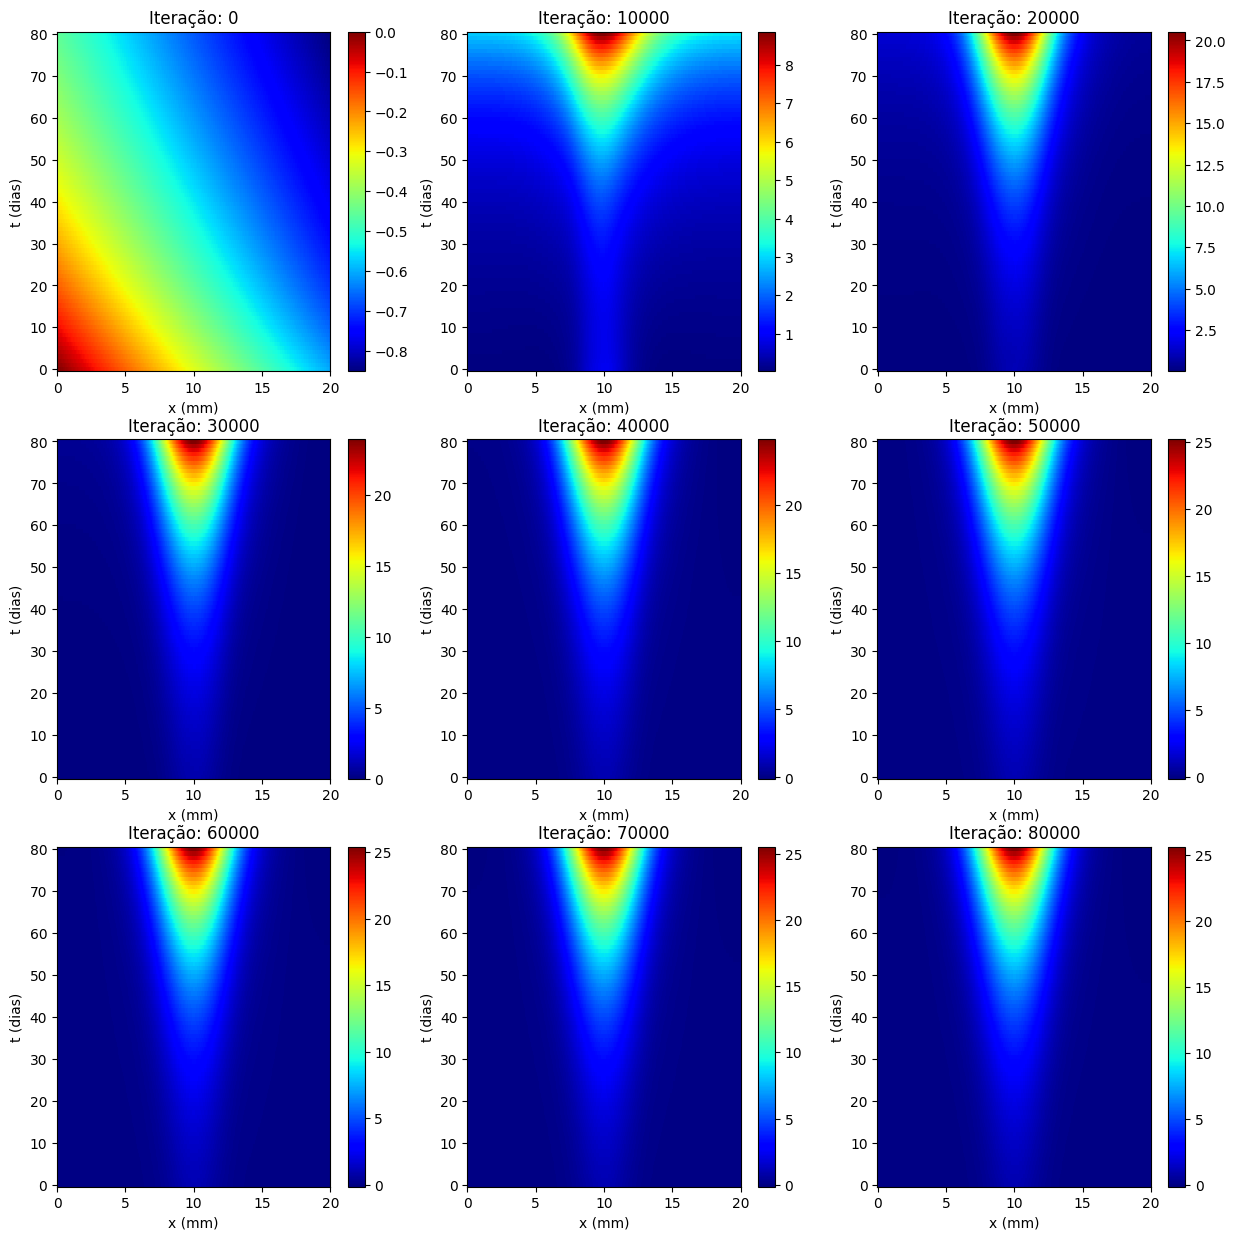

In [ ]:
# INICIALIZAÇÃO DO MODELO
model = treinamento(1000, 50, 0)

# INICIAÇÃO DAS VARIÁVEIS
x = torch.linspace(0, 1, 1000)
t = torch.linspace(0, TF * P, 80)
input = torch.cartesian_prod(x, t)

fig, ax = plt.subplots(ncols=3, nrows=3, figsize = (15, 15))

for i in range(3):
    for j in range(3):

        # PREDIÇÃO DO MODELO
        output = model.predict(input)
        output = output.reshape(1000, 80).T

        # PLOTAGEM
        p = ax[i, j].pcolormesh(x * L, t / P, output, cmap='jet')
        ax[i, j].set_xlabel('x (mm)')
        ax[i, j].set_ylabel('t (dias)')
        ax[i,j].set_title(f'Iteração: {j * 10_000 + i * 30_000}')
        plt.colorbar(p)

        # TREINAMENTO
        losshistory, train_state = model.train(10_000)

plt.show()

In [ ]:
class Murray_FDM:

    a: np.ndarray
    b: np.ndarray

    def __init__(self, l, tf, d, p, dx, dt, size):



        dl = d / (p * l**2)
        lb = (dl * dt) / dx**2
        gamma1 = 1. - 0.5 * dt + lb
        gamma2 = 1. + 0.5 * dt - lb

        a = np.zeros((size, size))
        b = np.zeros((size, size))

        a[0,0], b[0,0] = 3 / (2 * dx), -3 / (2 * dx)
        a[0,1], b[0,1] = -4 / (2 * dx), 4 / (2 * dx)
        a[0,2], b[0,2] = 1 / (2 * dx), -1 / (2 * dx)

        a[-1, -1], b[-1, -1] = -3 / (2 * dx), 3 / (2 * dx)
        a[-1, -2], b[-1, -2] = 4 / (2 * dx), -4 / (2 * dx)
        a[-1, -3], b[-1, -3] = -1 / (2 * dx), 1 / (2 * dx)

        for i in range(1, size-1):
            a[i, i], b[i,i] = gamma1, gamma2
            a[i, i+1], b[i,i+1] = -0.5 * lb, 0.5 * lb
            a[i, i-1], b[i,i-1] = -0.5 * lb, 0.5 * lb

        self.a = a
        self.b = b

    def __call__(self, x):

        dir = self.b @ x
        return np.linalg.solve(self.a, dir)

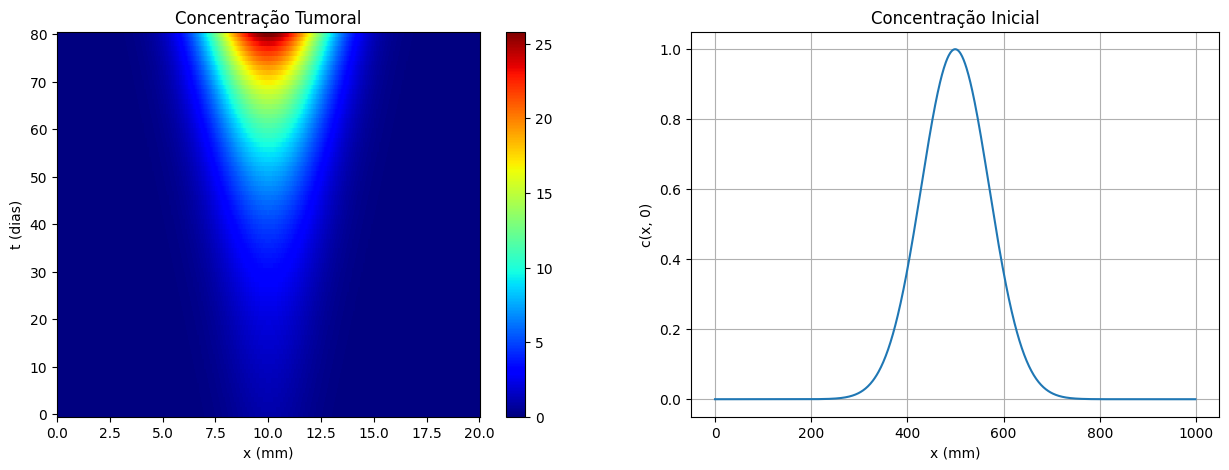

In [ ]:
x_fdm = np.linspace(0, 1, 1000)
t_fdm = np.linspace(0, TF * P, TF)

murray = Murray_FDM(L, TF, D, P, x_fdm[1], t_fdm[1], len(x_fdm))

result = np.zeros((TF, len(x)))
result[0] = np.exp(-100 * (x - 0.5)**2)
for i in range(1, TF): result[i] = murray(result[i-1])

fig, ax = plt.subplots(ncols=2, figsize = (15, 5))
p1 = ax[0].pcolormesh(x_fdm * L, t_fdm / P, result, cmap = 'jet')
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('t (dias)')
ax[0].set_title('Concentração Tumoral')

ax[1].plot(result[0])
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('c(x, 0)')
ax[1].set_title('Concentração Inicial')
ax[1].grid()
plt.colorbar(p1)
plt.show()

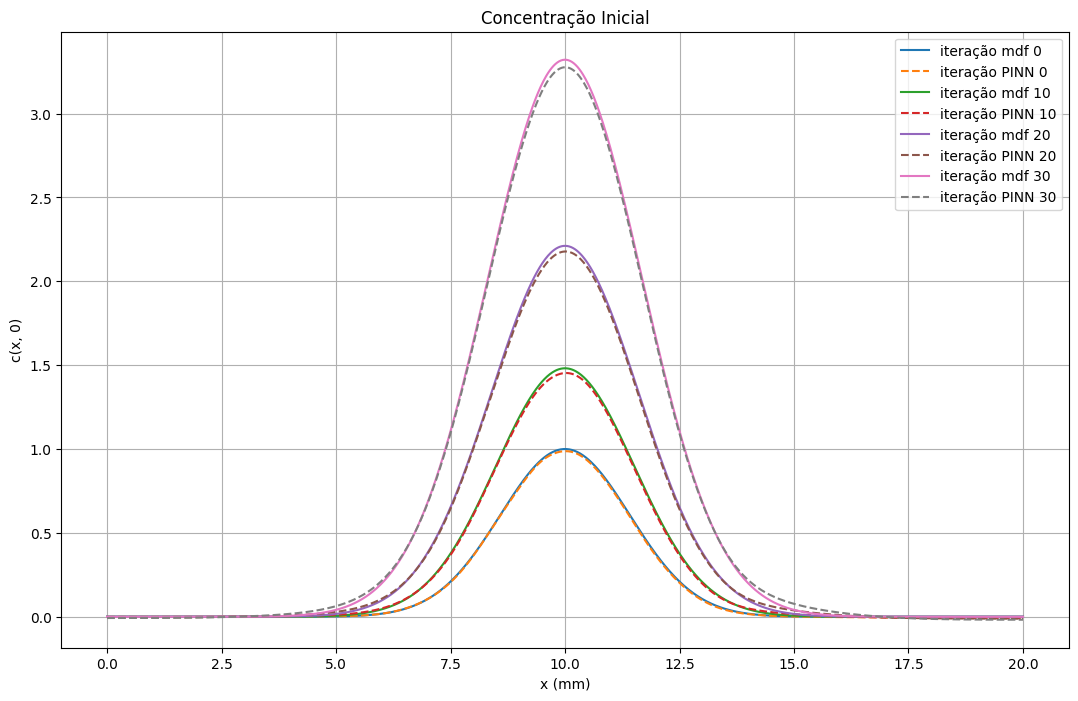

In [ ]:
fig, ax = plt.subplots(figsize = (13, 8))

for i in range(4):
    plt.plot(x * L, result[i*10], label = f'iteração mdf {i * 10}')
    plt.plot(x * L, output[i*10], linestyle = 'dashed', label = f'iteração PINN {i * 10}')
plt.xlabel('x (mm)')
plt.ylabel('c(x, 0)')
plt.title('Concentração Inicial')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def erro(pred, ref):

    return (1. - np.linalg.norm(pred - ref) / np.linalg.norm(ref)) * 100

erro(output.flatten(), result.flatten())

98.64848709468734

In [ ]:
# INICIALIZAÇÃO DO MODELO


error = np.zeros((3, 10))
for i in range(3):

    model = treinamento(1000, (i+1) * 50, 0)

    for j in range(10):

        # PREDIÇÃO DO MODELO
        output = model.predict(input)
        output = output.reshape(1000, 80).T

        # CALCULO DO ERRO
        error[i, j] = erro(output.flatten(), result.flatten())

        # TREINAMENTO
        losshistory, train_state = model.train(10_000)

error

Compiling model...
Building feed-forward neural network...
'build' took 0.084181 s

'compile' took 0.635491 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.64e-01, 3.71e-01, 2.41e-01]    [2.27e-01, 3.71e-01, 2.41e-01]    []  

Best model at step 0:
  train loss: 7.76e-01
  test loss: 8.39e-01
  test metric: []

'train' took 1.190695 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.64e-01, 3.71e-01, 2.41e-01]    [2.27e-01, 3.71e-01, 2.41e-01]    []  
1000      [1.09e-02, 4.84e-02, 6.49e-04]    [2.38e-02, 4.84e-02, 6.49e-04]    []  
2000      [1.77e-02, 4.05e-03, 4.03e-05]    [4.70e-02, 4.05e-03, 4.03e-05]    []  
3000      [1.71e-02, 3.66e-03, 2.37e-05]    [4.57e-02, 3.66e-03, 2.37e-05]    []  
4000      [1.65e-02, 3.45e-03, 2.75e-05]    [4.42e-02, 3.45e-03, 2.75e-05]    []  
5000      [1.55e-02, 3.19e-03, 4.09e-05]    [4.15e-02, 3.19e-

array([[-6.76204941, 37.84404822, 75.98862528, 80.15830336, 81.00588517,
        81.35881323, 81.65377486, 81.54021216, 81.23558281, 80.83565202],
       [-5.35043673, 56.3290287 , 70.74637694, 70.80869761, 69.9131685 ,
        68.37842632, 66.80386425, 65.18219673, 63.55633101, 61.93609834],
       [ 3.0079185 , 51.22003735, 78.38944309, 76.80298594, 73.88699449,
        70.49021828, 67.30353638, 64.10022563, 61.29478821, 58.36906696]])

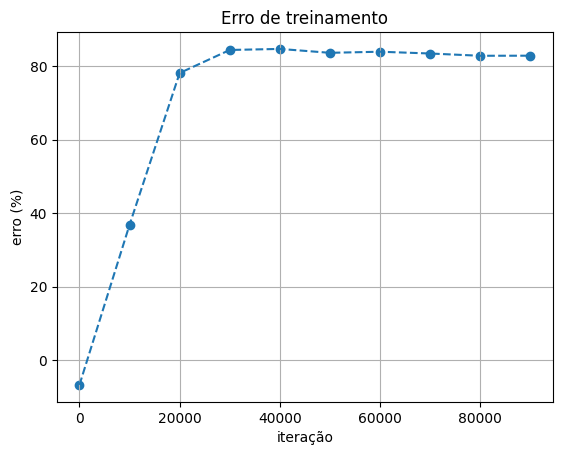

In [ ]:
pontos_colocacao = [i * 10_000 for i in range(10)]

for i in range(3):
    plt.plot(pontos_colocacao, error[i], linestyle = 'dashed', label = f'{(i+1) * 50} neurônios p. c.')
    plt.scatter(pontos_colocacao, error[i])

plt.grid()
plt.xlabel('iteração')
plt.ylabel('erro (%)')
plt.title('Erro de treinamento')
plt.show()
